2/17

As established before, L1 penalty works when converting a vector to a diagonal.

Now we want to see what increasing lambda works.

In addition see if we can match reconstruction of latent space from a pretrained VAE.

Then see:

What pixels does it selection? how does the reconstruction work? Generated samples

In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision import datasets
import torchvision.transforms as transforms


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

from torchvision.utils import save_image

import matplotlib.pyplot as plt

In [2]:
import os
from os import listdir

In [3]:
BASE_PATH_DATA = '../data/'

In [4]:
n_epochs = 5
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
img_size = 28
channels = 1

log_interval = 100


z_size = 20

In [5]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")

In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        BASE_PATH_DATA + '/mnist/train',
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor()]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        BASE_PATH_DATA + '/mnist/test', 
        train=False, 
        download = True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor()]
        )
    ),
    batch_size=batch_size, shuffle=True
)

In [7]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [8]:
class VAE(nn.Module):
    def __init__(self, hidden_layer_size, z_size):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, hidden_layer_size)
        self.fc21 = nn.Linear(hidden_layer_size, z_size)
        self.fc22 = nn.Linear(hidden_layer_size, z_size)
        self.fc3 = nn.Linear(z_size, hidden_layer_size)
        self.fc4 = nn.Linear(hidden_layer_size, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [10]:
class VAE_l1_diag(nn.Module):
    def __init__(self, hidden_layer_size, z_size):
        super(VAE_l1_diag, self).__init__()
        
        self.diag = nn.Parameter(torch.normal(torch.zeros(784), 
                                 torch.ones(784)).to(device).requires_grad_(True))
        
        self.selection_layer = torch.diag(self.diag)
        self.fc1 = nn.Linear(784, hidden_layer_size)
        self.fc21 = nn.Linear(hidden_layer_size, z_size)
        self.fc22 = nn.Linear(hidden_layer_size, z_size)
        self.fc3 = nn.Linear(z_size, hidden_layer_size)
        self.fc4 = nn.Linear(hidden_layer_size, 784)

    def encode(self, x):
        h0 = torch.mm(x, self.selection_layer)
        h1 = F.relu(self.fc1(h0))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


Load pre-trained model

In [10]:
pretrained_model = VAE(400, 20).to(device)
pretrained_model.load_state_dict(torch.load(BASE_PATH_DATA + "../data/models/first_try/no_norm.pt"))
pretrained_model.eval()
pretrained_model.requires_grad_(False)

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)

Let's train a bunch of models and test the lambdas.

Basically, see if changing $\lambda$ for regularization makes it zero stuff out.

In [11]:
def train_l1_diag_added(model, optimizer, epoch, reg_lambda):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        
        l1_norm = reg_lambda * torch.norm(model.diag, p=1)
        loss += l1_norm
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \t L1 Loss: {}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data), l1_norm / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [12]:
def test(model, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         '../data/first_test_results_l1_on_loss_diag_lambda/reconstruction_' + 
                           str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [13]:
#diag_model = VAE_l1_diag(400, 20).to(device)
#optimizer = torch.optim.Adam(diag_model.parameters(), lr=lr, betas = (b1,b2))

In [14]:
reg_lambda = 10
for epoch in range(1, n_epochs + 1):
        train_l1_diag_added(diag_model, optimizer, epoch, reg_lambda)
        #with torch.no_grad():
        #    diag_model.diag.data[torch.abs(diag_model.diag) < 0.05] = 0
        test(diag_model, epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = diag_model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       '../data/first_test_results_l1_on_loss_diag_lambda/sample_' + str(epoch) + '.png')

NameError: name 'diag_model' is not defined

In [15]:
dia = np.abs(diag_model.diag.clone().detach().cpu().numpy())
print(np.histogram(dia, bins = [0, 0.01, 0.1, 0.5, 1, 2, 3]))

(array([503,  26, 135,  80,  39,   1]), array([0.  , 0.01, 0.1 , 0.5 , 1.  , 2.  , 3.  ]))


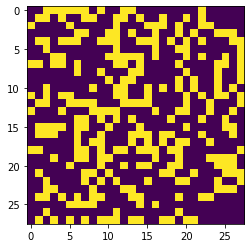

In [16]:
plt.imshow(dia.reshape((28, 28)) > 0.01)

In [17]:
np.sum(np.isclose(dia, 0))

0

For some reason, training does not work inside functions. Going to do 10 tries.

In [15]:
def try_model(reg_lambda):
    torch.manual_seed(123)

    model = VAE_l1_diag(400, 20).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas = (b1,b2))
    
    for epoch in range(1, n_epochs + 1):
        train_l1_diag_added(model, optimizer, epoch, reg_lambda)
        #with torch.no_grad():
        #    model.diag.data[torch.abs(model.diag) < 0.05] = 0
        print(model.diag)
        test(model, epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       '../data/first_test_results_l1_on_loss_diag_lambda/sample_' + str(epoch) + '.png')
    
    dia = np.abs(model.diag.clone().detach().cpu().numpy())
    print("Values on diagonal")
    print(dia)
    print("How many are close to zero?")
    print(np.sum(np.isclose(dia, 0)))
    print("Histogram of diagonal")
    print(np.histogram(dia, bins = [0, 0.01, 0.1, 0.5, 1, 2, 3]))
    
    plt.imshow(dia.reshape((28, 28)))
    
    torch.save(model.state_dict(), BASE_PATH_DATA + 
               "../data/models/with_regularization/l1_norm_diag_100_lambda.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.337708 	 L1 Loss: 0.0
Train Epoch: 1 [6400/60000 (11%)]	Loss: 231.513397 	 L1 Loss: 0.0
Train Epoch: 1 [12800/60000 (21%)]	Loss: 206.456970 	 L1 Loss: 0.0
Train Epoch: 1 [19200/60000 (32%)]	Loss: 184.491959 	 L1 Loss: 0.0
Train Epoch: 1 [25600/60000 (43%)]	Loss: 177.409302 	 L1 Loss: 0.0
Train Epoch: 1 [32000/60000 (53%)]	Loss: 171.334045 	 L1 Loss: 0.0
Train Epoch: 1 [38400/60000 (64%)]	Loss: 160.273727 	 L1 Loss: 0.0
Train Epoch: 1 [44800/60000 (75%)]	Loss: 156.049210 	 L1 Loss: 0.0
Train Epoch: 1 [51200/60000 (85%)]	Loss: 147.467911 	 L1 Loss: 0.0
Train Epoch: 1 [57600/60000 (96%)]	Loss: 155.253815 	 L1 Loss: 0.0
====> Epoch: 1 Average loss: 191.4934
====> Test set loss: 149.0534
Train Epoch: 2 [0/60000 (0%)]	Loss: 147.382172 	 L1 Loss: 0.0
Train Epoch: 2 [6400/60000 (11%)]	Loss: 145.195206 	 L1 Loss: 0.0
Train Epoch: 2 [12800/60000 (21%)]	Loss: 147.695312 	 L1 Loss: 0.0
Train Epoch: 2 [19200/60000 (32%)]	Loss: 137.522522 	 L1 Loss: 0.0
Train 

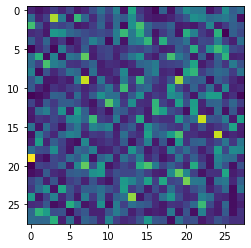

In [19]:
try_model(0.0)

Train Epoch: 1 [0/60000 (0%)]	Loss: 551.296692 	 L1 Loss: 0.9589571356773376
Train Epoch: 1 [6400/60000 (11%)]	Loss: 232.464874 	 L1 Loss: 0.951478123664856
Train Epoch: 1 [12800/60000 (21%)]	Loss: 207.400589 	 L1 Loss: 0.943612277507782
Train Epoch: 1 [19200/60000 (32%)]	Loss: 185.430313 	 L1 Loss: 0.9383530616760254
Train Epoch: 1 [25600/60000 (43%)]	Loss: 178.342285 	 L1 Loss: 0.9329803586006165
Train Epoch: 1 [32000/60000 (53%)]	Loss: 172.261002 	 L1 Loss: 0.9269614219665527
Train Epoch: 1 [38400/60000 (64%)]	Loss: 161.194672 	 L1 Loss: 0.9209471940994263
Train Epoch: 1 [44800/60000 (75%)]	Loss: 156.964081 	 L1 Loss: 0.9148744940757751
Train Epoch: 1 [51200/60000 (85%)]	Loss: 148.376801 	 L1 Loss: 0.9088882803916931
Train Epoch: 1 [57600/60000 (96%)]	Loss: 156.156891 	 L1 Loss: 0.9030815362930298
====> Epoch: 1 Average loss: 192.4227
====> Test set loss: 149.0534
Train Epoch: 2 [0/60000 (0%)]	Loss: 148.283127 	 L1 Loss: 0.9009548425674438
Train Epoch: 2 [6400/60000 (11%)]	Loss: 146

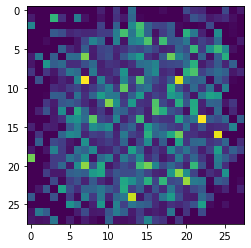

In [20]:
try_model(0.1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 559.927307 	 L1 Loss: 9.589570999145508
Train Epoch: 1 [6400/60000 (11%)]	Loss: 240.950974 	 L1 Loss: 9.437580108642578
Train Epoch: 1 [12800/60000 (21%)]	Loss: 215.739273 	 L1 Loss: 9.282309532165527
Train Epoch: 1 [19200/60000 (32%)]	Loss: 193.639191 	 L1 Loss: 9.147233009338379
Train Epoch: 1 [25600/60000 (43%)]	Loss: 186.418381 	 L1 Loss: 9.009073257446289
Train Epoch: 1 [32000/60000 (53%)]	Loss: 180.201035 	 L1 Loss: 8.866989135742188
Train Epoch: 1 [38400/60000 (64%)]	Loss: 168.999756 	 L1 Loss: 8.726024627685547
Train Epoch: 1 [44800/60000 (75%)]	Loss: 164.636658 	 L1 Loss: 8.587449073791504
Train Epoch: 1 [51200/60000 (85%)]	Loss: 155.918808 	 L1 Loss: 8.45089054107666
Train Epoch: 1 [57600/60000 (96%)]	Loss: 163.570831 	 L1 Loss: 8.317023277282715
====> Epoch: 1 Average loss: 200.4126
====> Test set loss: 149.0534
Train Epoch: 2 [0/60000 (0%)]	Loss: 155.649689 	 L1 Loss: 8.267521858215332
Train Epoch: 2 [6400/60000 (11%)]	Loss: 153.332428 	 

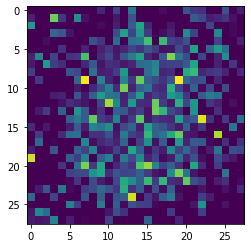

In [21]:
try_model(1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 646.233398 	 L1 Loss: 95.89570617675781
Train Epoch: 1 [6400/60000 (11%)]	Loss: 325.070648 	 L1 Loss: 93.55724334716797
Train Epoch: 1 [12800/60000 (21%)]	Loss: 297.695923 	 L1 Loss: 91.23896789550781
Train Epoch: 1 [19200/60000 (32%)]	Loss: 273.493530 	 L1 Loss: 89.00155639648438
Train Epoch: 1 [25600/60000 (43%)]	Loss: 264.183441 	 L1 Loss: 86.77413940429688
Train Epoch: 1 [32000/60000 (53%)]	Loss: 255.908432 	 L1 Loss: 84.57438659667969
Train Epoch: 1 [38400/60000 (64%)]	Loss: 242.681458 	 L1 Loss: 82.40773010253906
Train Epoch: 1 [44800/60000 (75%)]	Loss: 236.328918 	 L1 Loss: 80.27970886230469
Train Epoch: 1 [51200/60000 (85%)]	Loss: 225.657959 	 L1 Loss: 78.19005584716797
Train Epoch: 1 [57600/60000 (96%)]	Loss: 231.381226 	 L1 Loss: 76.1274185180664
====> Epoch: 1 Average loss: 276.9237
====> Test set loss: 149.0534
Train Epoch: 2 [0/60000 (0%)]	Loss: 222.736404 	 L1 Loss: 75.35423278808594
Train Epoch: 2 [6400/60000 (11%)]	Loss: 218.531906 	 

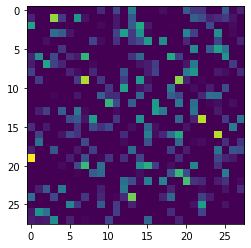

In [22]:
try_model(10)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1508.279785 	 L1 Loss: 958.9569091796875
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1166.399536 	 L1 Loss: 934.5989379882812
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1116.780273 	 L1 Loss: 910.7734375
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1073.655884 	 L1 Loss: 887.41357421875
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1040.161499 	 L1 Loss: 864.4405517578125
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1014.205872 	 L1 Loss: 841.941650390625
Train Epoch: 1 [38400/60000 (64%)]	Loss: 981.344971 	 L1 Loss: 819.8156127929688
Train Epoch: 1 [44800/60000 (75%)]	Loss: 953.498596 	 L1 Loss: 798.1431274414062
Train Epoch: 1 [51200/60000 (85%)]	Loss: 926.802917 	 L1 Loss: 776.8961181640625
Train Epoch: 1 [57600/60000 (96%)]	Loss: 912.262085 	 L1 Loss: 755.8489379882812
====> Epoch: 1 Average loss: 1042.7202
Parameter containing:
tensor([ 1.4977e-01,  6.4627e-05, -1.1592e-01, -4.0042e-01,  1.6100e-01,
         4.7276e-01, -3.2036e-02, -1.9157e-01,  5.7953e-01, -1.00

====> Test set loss: 149.2948
Train Epoch: 2 [0/60000 (0%)]	Loss: 892.755737 	 L1 Loss: 747.944091796875
Train Epoch: 2 [6400/60000 (11%)]	Loss: 868.927979 	 L1 Loss: 727.402587890625
Train Epoch: 2 [12800/60000 (21%)]	Loss: 849.203979 	 L1 Loss: 707.4584350585938
Train Epoch: 2 [19200/60000 (32%)]	Loss: 821.803833 	 L1 Loss: 688.0614624023438
Train Epoch: 2 [25600/60000 (43%)]	Loss: 810.287109 	 L1 Loss: 669.0742797851562
Train Epoch: 2 [32000/60000 (53%)]	Loss: 785.309692 	 L1 Loss: 650.5801391601562
Train Epoch: 2 [38400/60000 (64%)]	Loss: 770.515259 	 L1 Loss: 632.5104370117188
Train Epoch: 2 [44800/60000 (75%)]	Loss: 744.434570 	 L1 Loss: 614.8143310546875
Train Epoch: 2 [51200/60000 (85%)]	Loss: 725.905762 	 L1 Loss: 597.565673828125
Train Epoch: 2 [57600/60000 (96%)]	Loss: 711.527222 	 L1 Loss: 580.6875
====> Epoch: 2 Average loss: 797.7392
Parameter containing:
tensor([-7.2007e-05, -1.5373e-05, -5.9305e-05, -2.1282e-01,  4.2797e-05,
         2.8516e-01,  4.3714e-05, -3.9669e-03

====> Test set loss: 130.8337
Train Epoch: 3 [0/60000 (0%)]	Loss: 705.938599 	 L1 Loss: 574.340087890625
Train Epoch: 3 [6400/60000 (11%)]	Loss: 687.000549 	 L1 Loss: 557.8396606445312
Train Epoch: 3 [12800/60000 (21%)]	Loss: 672.979248 	 L1 Loss: 541.5952758789062
Train Epoch: 3 [19200/60000 (32%)]	Loss: 652.732422 	 L1 Loss: 525.6298828125
Train Epoch: 3 [25600/60000 (43%)]	Loss: 640.063599 	 L1 Loss: 509.97857666015625
Train Epoch: 3 [32000/60000 (53%)]	Loss: 627.102478 	 L1 Loss: 494.557373046875
Train Epoch: 3 [38400/60000 (64%)]	Loss: 601.171875 	 L1 Loss: 479.4364013671875
Train Epoch: 3 [44800/60000 (75%)]	Loss: 591.617493 	 L1 Loss: 464.7751770019531
Train Epoch: 3 [51200/60000 (85%)]	Loss: 581.323425 	 L1 Loss: 450.5428466796875
Train Epoch: 3 [57600/60000 (96%)]	Loss: 549.976685 	 L1 Loss: 436.63330078125
====> Epoch: 3 Average loss: 628.5786
Parameter containing:
tensor([ 7.9922e-06,  6.4626e-05, -5.9308e-05, -2.5218e-02, -3.7202e-05,
         9.7556e-02, -1.1628e-04, -4.69

====> Test set loss: 123.5403
Train Epoch: 4 [0/60000 (0%)]	Loss: 553.468628 	 L1 Loss: 431.4442138671875
Train Epoch: 4 [6400/60000 (11%)]	Loss: 540.967041 	 L1 Loss: 417.9312744140625
Train Epoch: 4 [12800/60000 (21%)]	Loss: 530.676941 	 L1 Loss: 404.6440124511719
Train Epoch: 4 [19200/60000 (32%)]	Loss: 526.368042 	 L1 Loss: 391.6502990722656
Train Epoch: 4 [25600/60000 (43%)]	Loss: 503.402374 	 L1 Loss: 378.9150390625
Train Epoch: 4 [32000/60000 (53%)]	Loss: 489.819885 	 L1 Loss: 366.402587890625
Train Epoch: 4 [38400/60000 (64%)]	Loss: 477.207611 	 L1 Loss: 354.21258544921875
Train Epoch: 4 [44800/60000 (75%)]	Loss: 458.569611 	 L1 Loss: 342.3146667480469
Train Epoch: 4 [51200/60000 (85%)]	Loss: 452.423096 	 L1 Loss: 330.8423767089844
Train Epoch: 4 [57600/60000 (96%)]	Loss: 439.818573 	 L1 Loss: 319.6082763671875
====> Epoch: 4 Average loss: 493.7952
Parameter containing:
tensor([-7.2007e-05, -1.5374e-05, -5.9311e-05, -9.8571e-05,  4.2798e-05,
         3.9766e-05,  4.3715e-05,  1

====> Test set loss: 118.8966
Train Epoch: 5 [0/60000 (0%)]	Loss: 437.351685 	 L1 Loss: 315.4112548828125
Train Epoch: 5 [6400/60000 (11%)]	Loss: 427.061768 	 L1 Loss: 304.5422668457031
Train Epoch: 5 [12800/60000 (21%)]	Loss: 412.246460 	 L1 Loss: 293.99072265625
Train Epoch: 5 [19200/60000 (32%)]	Loss: 401.200226 	 L1 Loss: 283.6061706542969
Train Epoch: 5 [25600/60000 (43%)]	Loss: 396.644592 	 L1 Loss: 273.4849548339844
Train Epoch: 5 [32000/60000 (53%)]	Loss: 387.310211 	 L1 Loss: 263.6423034667969
Train Epoch: 5 [38400/60000 (64%)]	Loss: 372.754364 	 L1 Loss: 253.91390991210938
Train Epoch: 5 [44800/60000 (75%)]	Loss: 361.991394 	 L1 Loss: 244.51174926757812
Train Epoch: 5 [51200/60000 (85%)]	Loss: 349.608795 	 L1 Loss: 235.28616333007812
Train Epoch: 5 [57600/60000 (96%)]	Loss: 346.199829 	 L1 Loss: 226.30955505371094
====> Epoch: 5 Average loss: 386.0790
Parameter containing:
tensor([ 7.9925e-06,  6.4626e-05, -5.9315e-05,  6.1428e-05, -3.7202e-05,
         7.7864e-05, -1.1628e-0

====> Test set loss: 115.8817
Values on diagonal
[7.99250211e-06 6.46261178e-05 5.93145742e-05 6.14280216e-05
 3.72020986e-05 7.78638569e-05 1.16284500e-04 4.69375773e-05
 6.76334530e-05 2.54531980e-01 5.31984515e-05 4.71720517e-01
 6.18975100e-05 9.57008898e-01 3.94692819e-07 8.24525923e-05
 6.00965104e-05 8.25291052e-02 8.03220682e-05 5.48880162e-05
 6.42920375e-01 3.63053769e-01 3.37318838e-01 7.33372326e-06
 5.46918272e-05 6.34257615e-01 2.86281779e-02 2.10180581e-01
 2.20902801e-01 2.33577202e-06 5.11646977e-05 1.90183830e+00
 3.86967480e-01 5.14052736e-05 1.19561207e+00 1.14381954e-01
 4.49625732e-05 7.56925219e-05 6.35461984e-05 1.48646399e-01
 1.90762639e-05 6.16086066e-01 1.68962470e-05 8.88474970e-05
 7.66325393e-05 2.49690293e-05 1.57316681e-05 1.65348429e-05
 4.88041696e-05 6.84085846e-01 5.39924204e-01 1.95145592e-01
 2.82316118e-01 3.75865728e-01 1.15350731e-01 8.39969143e-05
 1.30917573e+00 6.21812214e-05 4.23075835e-05 2.63221609e-05
 1.05802326e-04 1.16664058e-04 1.224

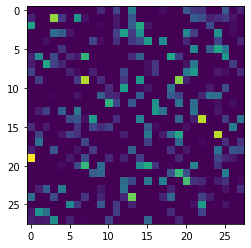

In [16]:
try_model(100)

Train Epoch: 1 [0/60000 (0%)]	Loss: 10139.909180 	 L1 Loss: 9589.5712890625
Train Epoch: 1 [6400/60000 (11%)]	Loss: 9577.977539 	 L1 Loss: 9346.4638671875
Train Epoch: 1 [12800/60000 (21%)]	Loss: 9314.967773 	 L1 Loss: 9108.5107421875
Train Epoch: 1 [19200/60000 (32%)]	Loss: 9059.156250 	 L1 Loss: 8874.6640625
Train Epoch: 1 [25600/60000 (43%)]	Loss: 8822.225586 	 L1 Loss: 8644.81640625
Train Epoch: 1 [32000/60000 (53%)]	Loss: 8591.192383 	 L1 Loss: 8419.8583984375
Train Epoch: 1 [38400/60000 (64%)]	Loss: 8358.989258 	 L1 Loss: 8198.7158203125
Train Epoch: 1 [44800/60000 (75%)]	Loss: 8138.083496 	 L1 Loss: 7982.0341796875
Train Epoch: 1 [51200/60000 (85%)]	Loss: 7917.041992 	 L1 Loss: 7769.57421875
Train Epoch: 1 [57600/60000 (96%)]	Loss: 7714.358887 	 L1 Loss: 7559.10498046875
====> Epoch: 1 Average loss: 8701.7704
====> Test set loss: 149.0534
Train Epoch: 2 [0/60000 (0%)]	Loss: 7627.444824 	 L1 Loss: 7480.0625
Train Epoch: 2 [6400/60000 (11%)]	Loss: 7419.895996 	 L1 Loss: 7274.70068

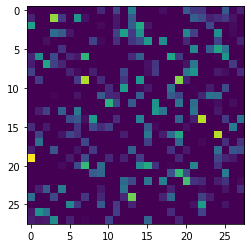

In [24]:
try_model(1000)

Let's see if we can have the same latent representation.

In [25]:
def train_l1_diag_pretrained(model, pretrained_model, optimizer, epoch, reg_lambda_l1, reg_lambda_latent):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        
        l1_norm = reg_lambda_l1 * torch.norm(model.diag, p=1)
        loss += l1_norm
        
        h1_pretrained = F.relu(pretrained_model.fc1(data.view(-1, 784)))
        h0 = torch.mm(data.view(-1, 784), model.selection_layer)
        h1_model = F.relu(model.fc1(h0))
        l2_loss = reg_lambda_latent * F.mse_loss(h1_model, h1_pretrained)
        loss += l2_loss
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \t L2 Loss:{}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data), l2_loss.item() / len(data)))
            
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [26]:
model_latent_test = VAE_l1_diag(400, 20).to(device)
optimizer = torch.optim.Adam(model_latent_test.parameters(), lr=lr, betas = (b1,b2))

In [22]:
def test(model, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         '../data/first_test_results_l1_diag_l2_latent/reconstruction_' + 
                           str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [28]:
for epoch in range(1, n_epochs + 1):
        train_l1_diag_pretrained(model_latent_test, pretrained_model, optimizer, epoch, 1, 10)
        #with torch.no_grad():
            #model_latent_test.diag.data[torch.abs(model_latent_test.diag) < 0.05] = 0
        test(diag_model, epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = diag_model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       '../data/first_test_results_l1_diag_l2_latent/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 562.123413 	 L2 Loss:0.038460634648799896
Train Epoch: 1 [6400/60000 (11%)]	Loss: 256.473633 	 L2 Loss:0.03955848142504692
Train Epoch: 1 [12800/60000 (21%)]	Loss: 226.817780 	 L2 Loss:0.03944063186645508
Train Epoch: 1 [19200/60000 (32%)]	Loss: 200.209961 	 L2 Loss:0.043069079518318176
Train Epoch: 1 [25600/60000 (43%)]	Loss: 177.876175 	 L2 Loss:0.042379580438137054
Train Epoch: 1 [32000/60000 (53%)]	Loss: 190.073914 	 L2 Loss:0.052397917956113815
Train Epoch: 1 [38400/60000 (64%)]	Loss: 167.445053 	 L2 Loss:0.054812487214803696
Train Epoch: 1 [44800/60000 (75%)]	Loss: 175.304138 	 L2 Loss:0.055363088846206665
Train Epoch: 1 [51200/60000 (85%)]	Loss: 175.594574 	 L2 Loss:0.06093953177332878
Train Epoch: 1 [57600/60000 (96%)]	Loss: 153.178101 	 L2 Loss:0.059384386986494064
====> Epoch: 1 Average loss: 201.2638
====> Test set loss: 115.2485
Train Epoch: 2 [0/60000 (0%)]	Loss: 162.697250 	 L2 Loss:0.062649667263031
Train Epoch: 2 [6400/60000 (11%)]	Lo

In [29]:
dia = np.abs(model_latent_test.diag.clone().detach().cpu().numpy())
print(np.histogram(dia, bins = [0, 0.01, 0.1, 0.5, 1, 2, 3]))

(array([294,  45, 215, 132,  92,   6]), array([0.  , 0.01, 0.1 , 0.5 , 1.  , 2.  , 3.  ]))


In [30]:
np.sum(np.isclose(dia, 0))

0

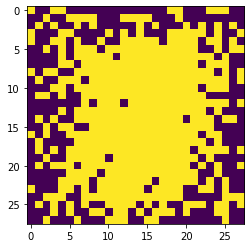

In [31]:
plt.imshow(dia.reshape((28, 28)) > 0.01)